In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("data.csv")
print(df.head())

   nodes   darts  time     pi
0      2  1000.0  0.09  3.124
1      4  1000.0  0.12  3.060
2      8  1000.0  0.16  3.170
3     16  1000.0  0.16    NaN
4     32  1000.0  0.18    NaN


In [8]:
df_dart_index = df.pivot(columns=["time", "nodes"], index="darts")
df_dart_index

pi                                                      \
time          0.09  0.12      0.16      0.18  0.23      0.11      0.14    
nodes            2     4         8   16    32    64        2         4    
darts                                                                     
1.000000e+03  3.124  3.06  3.170000 NaN   NaN   NaN       NaN       NaN   
1.000000e+06    NaN   NaN  3.141456 NaN   NaN   NaN  3.142444  3.140208   
1.000000e+09    NaN   NaN       NaN NaN   NaN   NaN       NaN       NaN   

                                                                        \
time             0.17     0.20      0.24      21.37    13.66     6.64    
nodes               16       32        64        2        4         8    
darts                                                                    
1.000000e+03       NaN      NaN       NaN       NaN      NaN       NaN   
1.000000e+06  3.141988  3.14097  3.144331       NaN      NaN       NaN   
1.000000e+09       NaN      NaN       NaN  3.141639  3.14161  3.141628   

                                            
time             3.41      1.80      1.02   
nodes               16        32        64  
darts                                       
1.000000e+03       NaN       NaN       NaN  
1.000000e+06       NaN       NaN       NaN  
1.000000e+09  3.141632  3.141579  3.141566

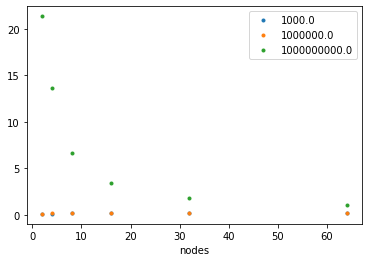

In [11]:
fig, ax = plt.subplots()
for key, grp in df.groupby(["darts"]):
    grp.plot(ax=ax, label=key, x="nodes", y="time", kind="line", linestyle='None', marker='.')
plt.savefig("pi_scaling.png")